In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

from sklearn import preprocessing
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from keras.layers import Activation
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score

# Data Pre-processing

In [11]:
# Read csv
df = pd.read_csv("../compiled.csv")

# Remove 5-tuple
new_df = df.iloc[:, 5:].copy()

# Replace "inf" with numpy.nan
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns containing numpy.nan
new_df = new_df.dropna()

# Dataset Info
print(new_df.shape)
print(new_df['Label'].value_counts())
#print(df.info())
#print(df['Label'].describe())

(18697, 24)
Label
3    5611
5    5244
1    5071
2    1847
4     711
0     213
Name: count, dtype: int64


# Over Sampling (SMOTE)

In [12]:
# Separate features and labels
X = new_df.drop('Label', axis=1)
y = new_df['Label']

smote = SMOTE(sampling_strategy='auto', random_state=123)

X_res, y_res = smote.fit_resample(X, y)

# Convert resampled features and labels back to dataframes
X_res_df = pd.DataFrame(X_res, columns=X.columns)
y_res_df = pd.DataFrame(y_res, columns=['Label'])


# Normalise values
x = X_res_df
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)
y = y_res_df

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=32)

# Reshape
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train_cnn= to_categorical(y_train)
y_test_cnn = to_categorical(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

y_res_df.value_counts()

(23566, 23)
(23566, 1)
(10100, 23)
(10100, 1)


Label
0        5611
1        5611
2        5611
3        5611
4        5611
5        5611
Name: count, dtype: int64

In [13]:
# Confusion matrix 
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_pred, y_test)

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', size='xx-large')

    # Plot confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(6)
    plt.xticks(tick_marks, label_dict.values())
    plt.yticks(tick_marks, label_dict.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
# Dictionary to store results
results_dictionary = {}

# Labels Dictionary
label_dict = {
    0: "Chat",
    1: "Email",
    2: "File Transfer",
    3: "Streaming",
    4: "VoIP",
    5: "Gaming"
}

# Model Training

In [5]:
# Create the CNN Model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv1D(128, 3, input_shape=(X_train.shape[1], 1), strides=1, activation = 'relu'))
# 2nd Convolution Layer
model.add(Conv1D(filters=128, kernel_size=3, strides=1, activation = 'relu'))
# Max Pooling and Dropout Layer
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(0.25))

# 3rd Convolution Layer
model.add(Conv1D(filters=128, kernel_size=3, strides=1, activation = 'relu'))
# 4th Convolution Layer
model.add(Conv1D(filters=128, kernel_size=3, strides=1, activation = 'relu'))
#Max Pooling and Dropout Layer
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(0.25))

# Fully Connected layer
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

# Output Layer
model.add(Dense(y_test_cnn.shape[1], activation='softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

model.fit(X_train_cnn, y_train_cnn, epochs = 200, validation_data = (X_test_cnn, y_test_cnn))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 21, 128)           512       
                                                                 
 conv1d_1 (Conv1D)           (None, 19, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 128)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 9, 128)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 128)            49280     
                                                                 
 conv1d_3 (Conv1D)           (None, 5, 128)            49280     
                                                        

Epoch 100/200
737/737 [==============================] - 6s 9ms/step - loss: 0.7551 - accuracy: 0.7187 - val_loss: 0.7839 - val_accuracy: 0.7150
Epoch 101/200
737/737 [==============================] - 6s 8ms/step - loss: 0.7496 - accuracy: 0.7193 - val_loss: 0.7688 - val_accuracy: 0.7204
Epoch 102/200
737/737 [==============================] - 6s 9ms/step - loss: 0.7575 - accuracy: 0.7172 - val_loss: 0.7656 - val_accuracy: 0.7261
Epoch 103/200
737/737 [==============================] - 6s 8ms/step - loss: 0.7467 - accuracy: 0.7217 - val_loss: 0.7612 - val_accuracy: 0.7278
Epoch 104/200
737/737 [==============================] - 6s 9ms/step - loss: 0.7429 - accuracy: 0.7235 - val_loss: 0.7705 - val_accuracy: 0.7258
Epoch 105/200
737/737 [==============================] - 6s 9ms/step - loss: 0.7549 - accuracy: 0.7182 - val_loss: 0.7577 - val_accuracy: 0.7387
Epoch 106/200
737/737 [==============================] - 6s 9ms/step - loss: 0.7489 - accuracy: 0.7202 - val_loss: 0.7692 - val_ac

316/316 [==============================] - 1s 2ms/step


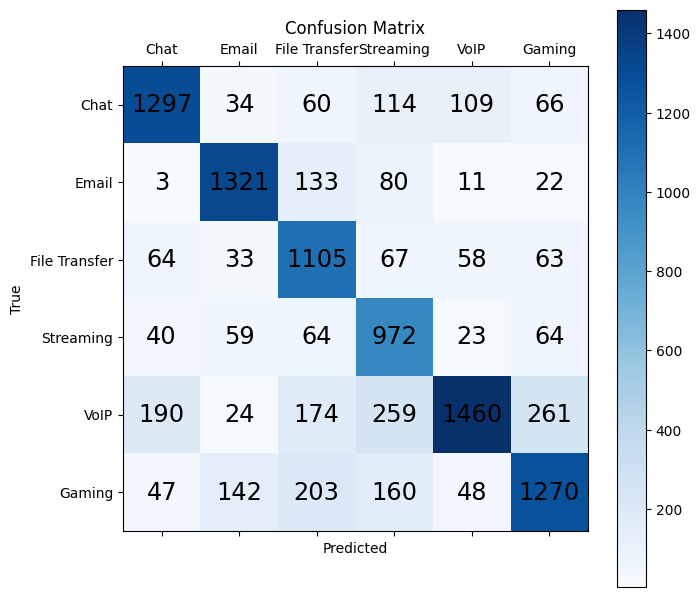

               precision    recall  f1-score   support

         Chat     0.7720    0.7904    0.7811      1641
        Email     0.8414    0.8190    0.8300      1613
File Transfer     0.7950    0.6354    0.7063      1739
    Streaming     0.7954    0.5884    0.6764      1652
         VoIP     0.6166    0.8543    0.7162      1709
       Gaming     0.6791    0.7274    0.7024      1746

     accuracy                         0.7351     10100
    macro avg     0.7499    0.7358    0.7354     10100
 weighted avg     0.7485    0.7351    0.7343     10100



In [6]:
y_pred = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred, axis=1)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_test, y_pred, digits=4, target_names=label_dict.values()))

# Store Results
results_dictionary["CNN"] = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


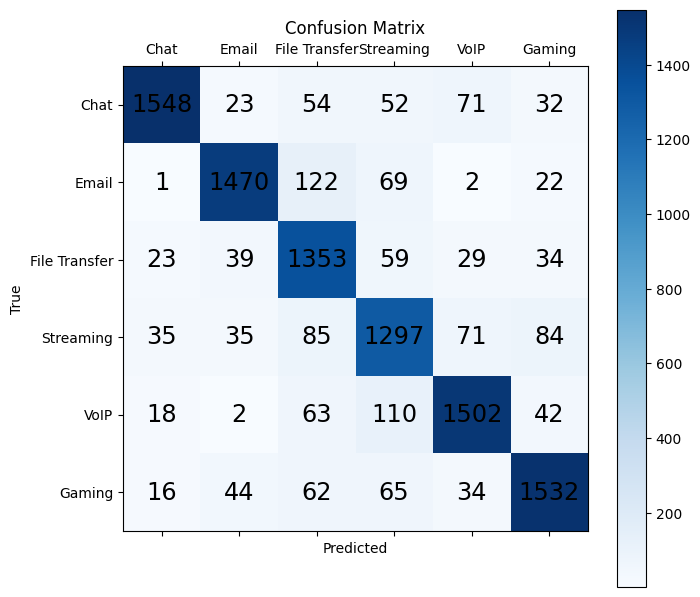

               precision    recall  f1-score   support

         Chat     0.8697    0.9433    0.9050      1641
        Email     0.8719    0.9113    0.8912      1613
File Transfer     0.8803    0.7780    0.8260      1739
    Streaming     0.8071    0.7851    0.7959      1652
         VoIP     0.8647    0.8789    0.8717      1709
       Gaming     0.8739    0.8774    0.8757      1746

     accuracy                         0.8616     10100
    macro avg     0.8613    0.8624    0.8609     10100
 weighted avg     0.8615    0.8616    0.8607     10100



In [14]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_test, y_pred, digits=4, target_names=label_dict.values()))

# Store Results
results_dictionary["RandomForest"] = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

#Pickle model
with open('flow_RF_model.pkl', 'wb') as f:
    pickle.dump(rf, f)
    
with open('encoder.pkl', 'wb') as f:
    pickle.dump(min_max_scaler, f)

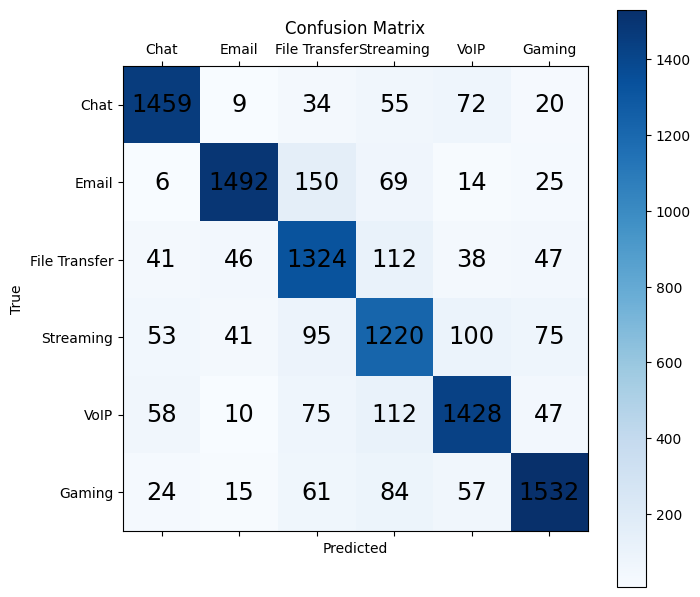

              precision    recall  f1-score   support

           0     0.8891    0.8848    0.8869      1649
           1     0.9250    0.8497    0.8857      1756
           2     0.7614    0.8234    0.7912      1608
           3     0.7385    0.7702    0.7540      1584
           4     0.8356    0.8254    0.8305      1730
           5     0.8774    0.8641    0.8707      1773

    accuracy                         0.8371     10100
   macro avg     0.8378    0.8363    0.8365     10100
weighted avg     0.8402    0.8371    0.8381     10100



In [15]:
decision_tree_clf = DecisionTreeClassifier(random_state=42)
decision_tree_clf.fit(X_train, y_train)
y_pred = decision_tree_clf.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_pred, y_test, digits=4))

# Store results
results_dictionary["DecisionTree"] =  [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


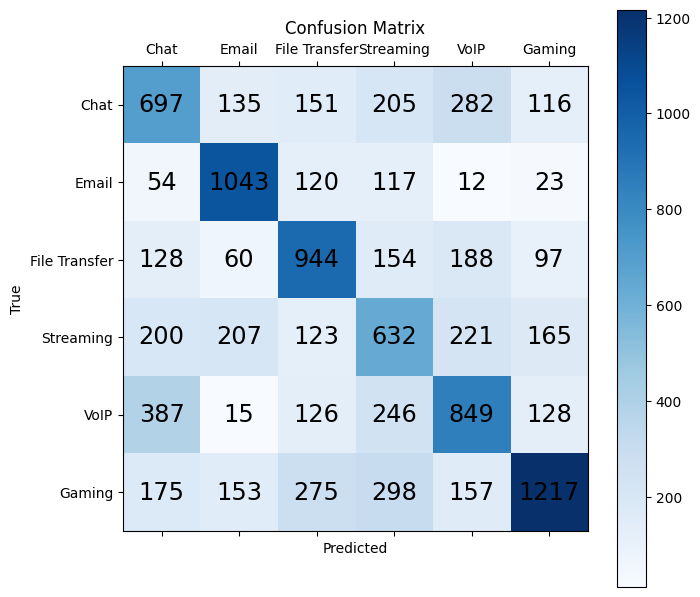

              precision    recall  f1-score   support

           0     0.4247    0.4395    0.4320      1586
           1     0.6466    0.7619    0.6995      1369
           2     0.5428    0.6009    0.5704      1571
           3     0.3826    0.4083    0.3950      1548
           4     0.4968    0.4849    0.4908      1751
           5     0.6970    0.5349    0.6053      2275

    accuracy                         0.5329     10100
   macro avg     0.5318    0.5384    0.5322     10100
weighted avg     0.5405    0.5329    0.5333     10100



In [16]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)
adaboost_clf.fit(X_train, y_train)
y_pred = adaboost_clf.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_pred, y_test, digits=4))

# Store results
results_dictionary["AdaBoost"] =  [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


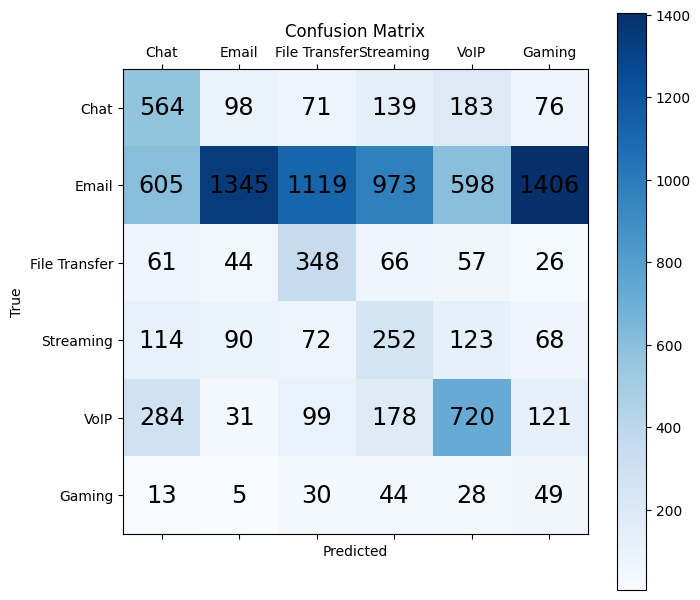

              precision    recall  f1-score   support

           0     0.3437    0.4987    0.4069      1131
           1     0.8338    0.2225    0.3512      6046
           2     0.2001    0.5781    0.2973       602
           3     0.1525    0.3505    0.2126       719
           4     0.4213    0.5024    0.4583      1433
           5     0.0281    0.2899    0.0512       169

    accuracy                         0.3246     10100
   macro avg     0.3299    0.4070    0.2963     10100
weighted avg     0.6207    0.3246    0.3545     10100



In [17]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_pred, y_test, digits=4))

# Store results
results_dictionary["LogisticRegression"] =  [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


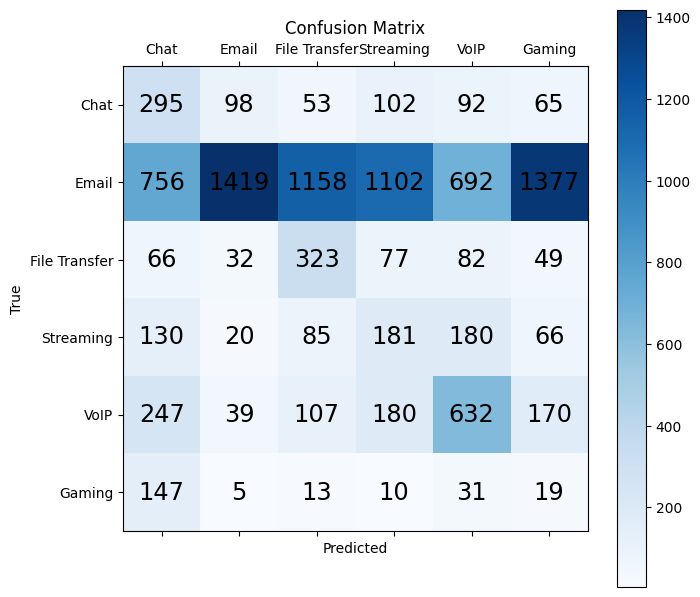

              precision    recall  f1-score   support

           0     0.1798    0.4184    0.2515       705
           1     0.8797    0.2182    0.3496      6504
           2     0.1857    0.5135    0.2728       629
           3     0.1096    0.2734    0.1564       662
           4     0.3698    0.4596    0.4099      1375
           5     0.0109    0.0844    0.0193       225

    accuracy                         0.2841     10100
   macro avg     0.2892    0.3279    0.2433     10100
weighted avg     0.6484    0.2841    0.3262     10100



In [18]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)
y_pred = nb_clf.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_pred, y_test, digits=4))

# Store results
results_dictionary["MultinomialNB"] =  [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


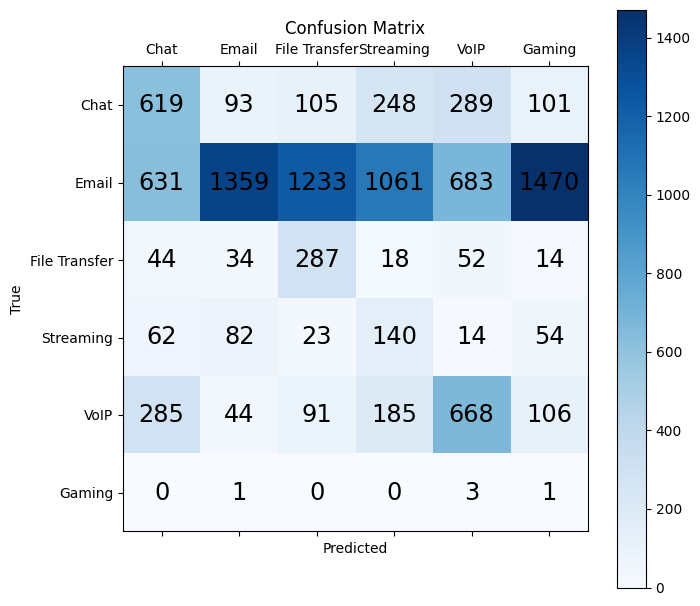

              precision    recall  f1-score   support

           0     0.3772    0.4254    0.3999      1455
           1     0.8425    0.2111    0.3376      6437
           2     0.1650    0.6392    0.2623       449
           3     0.0847    0.3733    0.1381       375
           4     0.3909    0.4844    0.4326      1379
           5     0.0006    0.2000    0.0011         5

    accuracy                         0.3044     10100
   macro avg     0.3102    0.3889    0.2620     10100
weighted avg     0.6552    0.3044    0.3487     10100



In [19]:
svm_clf = SVC(gamma = 'auto')
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_pred, y_test, digits=4))

# Store results
results_dictionary["SVM"] =  [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

In [7]:
result_df = pd.DataFrame(results_dictionary, index=['accuracy', 'precision', 'recall', 'f1'])
result_df = result_df.T
result_df

,accuracy,precision,recall,f1
CNN,0.735149,0.748517,0.735149,0.734331


In [20]:
result_df = pd.DataFrame(results_dictionary, index=['accuracy', 'precision', 'recall', 'f1'])
result_df = result_df.T
result_df

,accuracy,precision,recall,f1
RandomForest,0.861584,0.861513,0.861584,0.860658
DecisionTree,0.837129,0.836237,0.837129,0.836149
AdaBoost,0.532871,0.537834,0.532871,0.532402
LogisticRegression,0.324554,0.408548,0.324554,0.294561
MultinomialNB,0.284059,0.328338,0.284059,0.241942
SVM,0.304356,0.390499,0.304356,0.260058
